In [316]:
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem import SnowballStemmer
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from collections import Counter
import string
translator = str.maketrans('','',string.punctuation) 
stemmer = SnowballStemmer('english')

from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix
from linearmodels import PanelOLS

from numpy.random import randint
from wordcloud import WordCloud

import warnings
warnings.simplefilter('ignore')

In [22]:
cd data

/Users/tianqiwang/Desktop/robot_judge_hw/data


In [23]:
ls

case_metadata.csv  case_reversed.csv  cases/             feature_df.pkl


In [14]:
# read in the datasets
metadata = pd.read_csv('case_metadata.csv')
data = pd.read_pickle('feature_df.pkl')
doc_ids = data.index.tolist()

# Link the feature_df to the metadata
Y = metadata[metadata['caseid'].isin(doc_ids)]
Y = Y.sort_values(by = ['caseid'])
Y.head()

- Take your best-performing logistic regression model from Problem Set 1 (or train a new one).
- Use cross_val_predict() to form model predictions for each observation. 
- Construct a confusion matrix for the predictions. Report the precision_recall_curve() and roc_curve(). 
- Make a calibration plot 

In [309]:
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
X = sparse_scaler.fit_transform(data)

In [327]:
# train the logistic regression
clf = LogisticRegression(C = 0.1, penalty = 'l1')
y_pred = cross_val_predict(clf, X, Y.case_reversed, cv=5)

In [311]:
# confusion matrix
confusion_matrix(Y.case_reversed, y_pred)

array([[109, 259],
       [140, 492]])

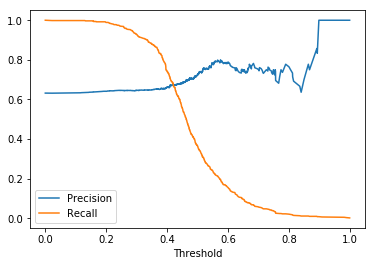

In [340]:
# Visualizing the precision/recall tradeoff
y_scores = cross_val_predict(clf,
                             X,
                             Y.case_reversed,
                             cv=5,
                             method='decision_function')

y_scores =(y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
precisions, recalls, thresholds = precision_recall_curve(Y.case_reversed, y_scores)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()

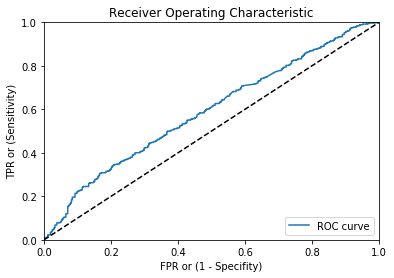

In [341]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y.case_reversed, y_scores)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR or (1 - Specifity)')
plt.ylabel('TPR or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

Text(0.5, 1.0, 'Calibration Curve')

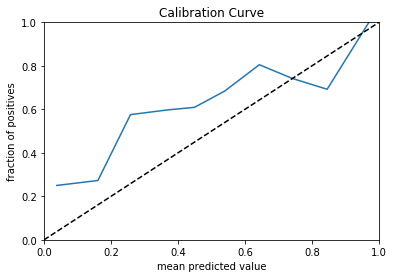

In [342]:
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(Y.case_reversed, y_scores, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('mean predicted value')
plt.ylabel('fraction of positives')
plt.title('Calibration Curve')

- Scale your n-gram frequencies while maintaining sparsity, as discussed in class.
- Train an elastic net model to predict log citations to a case (log_cites). 
- Run cross_val_predict() to form model predictions and report a scatter plot of true and predicted values. 

In [138]:
# remove NA from Y.log_cites
Y = Y.dropna(subset = ['log_cites'])
doc_ids = Y.caseid
X = data[data.index.isin(doc_ids)]
# scale the features
X = sparse_scaler.fit_transform(X)

In [134]:
# train elastic net model
reg = ElasticNet(alpha=2.0, l1_ratio=0.05)
# use cross_val_predict to form model predictions
y_pred = cross_val_predict(reg, X, Y.log_cites, cv=5)

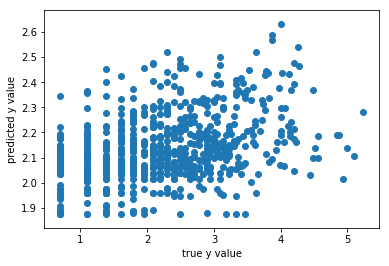

In [139]:
# plot the true and predicted values
plt.scatter(Y.log_cites, y_pred)
plt.xlabel('true y value')
plt.ylabel('predicted y value')
plt.show()

- Use the judge identifiers (judge_id) to produce the average citations to cases for each judge. 
- Then estimate a two-stage least-squares model with Z as average citations of the judge, X as citations to the case, and Y as whether the case was reversed. 
- Include year fixed effects.

In [166]:
# calculate average log_cites per judge
avg_cites = Y.groupby('judge_id')['log_cites'].mean().to_frame()
avg_cites.columns = ['judge_avg_cites']
Y = Y.merge(avg_cites, on = 'judge_id', how = 'left')
Y = Y.set_index(['judge_id','year'])
Y['const'] = 1

In [181]:
# Z: average log_cites per judge
# X: cites to the case
# Y: whether the case was reversed
# include year fixed effects

# first stage: X ~ Z
# second stage: Y ~ X

# first stage
mod = PanelOLS(Y['log_cites'], Y[['judge_avg_cites','const']], time_effects=True)
res = mod.fit(cov_type='clustered', cluster_time=True)
Y['X_hat'] = res.predict()

# second stage
mod = PanelOLS(Y['case_reversed'], Y[['X_hat','const']], time_effects=True)
res = mod.fit(cov_type='clustered', cluster_time=True)
res

Dep. Variable:,case_reversed,R-squared:,0.0206
Estimator:,PanelOLS,R-squared (Between):,-0.0115
No. Observations:,799,R-squared (Within):,0.0000
Date:,"Sat, Mar 30 2019",R-squared (Overall):,-0.0087
Time:,15:27:35,Log-likelihood,-484.57
Cov. Estimator:,Clustered,,
,,F-statistic:,14.881
Entities:,390,P-value,0.0001
Avg Obs:,2.0487,Distribution:,"F(1,709)"
Min Obs:,1.0000,,
Max Obs:,17.000,F-statistic (robust):,14.391


- Train LDA on the cases. 
- Produce word clouds for the topics. 
- Inspect the word clouds for different models to decide on the right number of topics.

In [220]:
# define clean_document() funtion, which helps to tokenize and clean the documents
newstop = ['court', 'v', 'us', 'state', 'case']
def clean_document(doc):
    doc = doc.translate(translator)
    doc = [i for i in doc.lower().split() if i not in stop and len(i) < 10]
    doc = [stemmer.stem(t) for t in doc if t not in newstop]
    return doc

In [221]:
# clean documents
from glob import glob
doc_clean = [clean_document(open(fname).read()) for fname in  glob('cases/*txt')[:1000]]

# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [222]:
# train LDA with 3 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=3, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

[(0,
  [('sct', 0.008252214),
   ('act', 0.007415185),
   ('district', 0.0067185666),
   ('state', 0.0063864538),
   ('would', 0.0050585466),
   ('f2d', 0.0049514887),
   ('unit', 0.0048338366),
   ('section', 0.0047829114),
   ('see', 0.004661733),
   ('claim', 0.004492688)]),
 (1,
  [('state', 0.008480342),
   ('act', 0.006739524),
   ('sct', 0.005935521),
   ('unit', 0.0058142543),
   ('district', 0.005184472),
   ('section', 0.0047116918),
   ('would', 0.0045674425),
   ('claim', 0.0044442564),
   ('see', 0.004427195),
   ('f2d', 0.0042340085)]),
 (2,
  [('state', 0.006831683),
   ('sct', 0.00598955),
   ('law', 0.005000814),
   ('district', 0.0049280045),
   ('would', 0.004927694),
   ('unit', 0.004895078),
   ('claim', 0.004691403),
   ('evid', 0.0041837166),
   ('trial', 0.0041742297),
   ('f2d', 0.003933448)])]

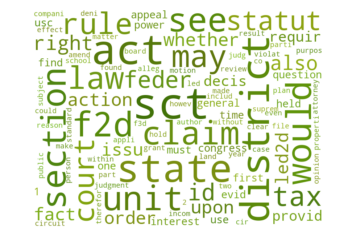

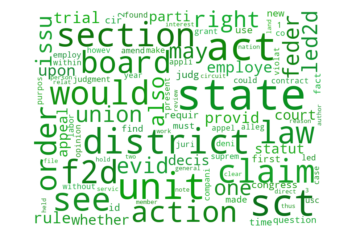

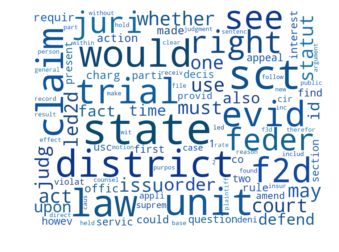

In [223]:
###
# LDA Word Clouds
###

# make directory if not exists
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i, weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    maincol = randint(0,360)
    
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [226]:
# train LDA with 5 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=5, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

[(0,
  [('state', 0.008420215),
   ('district', 0.008254995),
   ('sct', 0.0063937297),
   ('see', 0.0061532897),
   ('f2d', 0.005676537),
   ('evid', 0.005613886),
   ('would', 0.005409518),
   ('claim', 0.0053037833),
   ('trial', 0.0052439827),
   ('rule', 0.004558933)]),
 (1,
  [('act', 0.0063162707),
   ('claim', 0.006230199),
   ('section', 0.0057273265),
   ('tax', 0.0055237063),
   ('would', 0.004645778),
   ('sct', 0.004473743),
   ('law', 0.0040740143),
   ('state', 0.0040574195),
   ('right', 0.003858249),
   ('upon', 0.0036735975)]),
 (2,
  [('state', 0.012569068),
   ('unit', 0.010282197),
   ('f2d', 0.00636208),
   ('act', 0.005715166),
   ('sct', 0.005585679),
   ('district', 0.0053992043),
   ('would', 0.0053838906),
   ('claim', 0.0045457715),
   ('evid', 0.003810152),
   ('one', 0.0034049377)]),
 (3,
  [('act', 0.00876995),
   ('sct', 0.0073319804),
   ('law', 0.0067293253),
   ('state', 0.0055727814),
   ('district', 0.0054410724),
   ('board', 0.00518374),
   ('sect

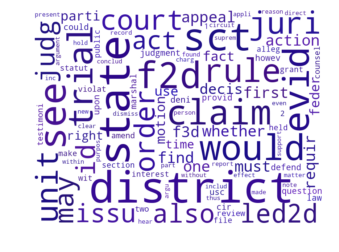

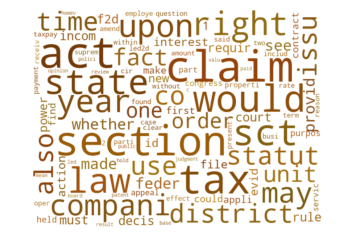

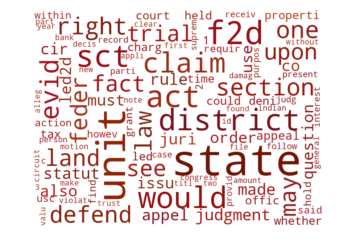

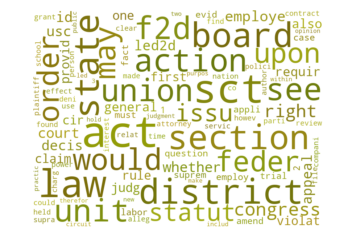

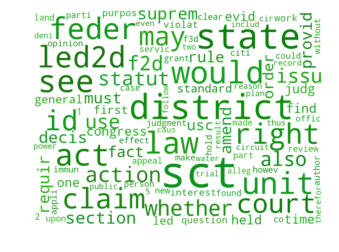

In [227]:
for i, weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    maincol = randint(0,360)
    
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

- Replicate your sklearn logistic regression model (no hidden layers, L2 regularization, and softmax output layer) in Keras or some other deep learning library.
- Compare performance.
- Now add two hidden layers, dropout, and batch normalization. 
- Compare performance.

In [231]:
# create training and testing setd
data = pd.read_pickle('feature_df.pkl')
doc_ids = data.index.tolist()
Y = metadata[metadata['caseid'].isin(doc_ids)]
Y = Y.sort_values(by = ['caseid'])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=0.33, random_state=42)

In [306]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

model = Sequential()
model.add(Dense(1,
          input_dim=1000,
          kernel_regularizer= regularizers.l2(),
          activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 1)                 1001      
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [307]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_info = model.fit(x_train, y_train.case_reversed, epochs=5, validation_data=(x_test, y_test.case_reversed))

Train on 670 samples, validate on 330 samples
Epoch 1/5
670/670 [==============================] - 1s 1ms/step - loss: 0.7060 - acc: 0.6045 - val_loss: 0.6989 - val_acc: 0.6576
Epoch 2/5
670/670 [==============================] - 0s 74us/step - loss: 0.6957 - acc: 0.6194 - val_loss: 0.6910 - val_acc: 0.6576
Epoch 3/5
670/670 [==============================] - 0s 70us/step - loss: 0.6903 - acc: 0.6194 - val_loss: 0.6869 - val_acc: 0.6576
Epoch 4/5
670/670 [==============================] - 0s 70us/step - loss: 0.6874 - acc: 0.6194 - val_loss: 0.6840 - val_acc: 0.6576
Epoch 5/5
670/670 [==============================] - 0s 73us/step - loss: 0.6856 - acc: 0.6194 - val_loss: 0.6815 - val_acc: 0.6576


In [304]:
###### add two hidden layers, dropout, and batch normalization
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout

model = Sequential()
model.add(Dense(64, input_dim=1000, kernel_regularizer= regularizers.l2(),activation='relu')) 

# batch normalization
model.add(BatchNormalization())
model.add(Activation('relu'))

# hidden layers
model.add(Dense(32, kernel_regularizer= regularizers.l2(), activation='relu'))
model.add(Dense(16, kernel_regularizer= regularizers.l2(), activation='relu'))

# Dropout
model.add(Dropout(0.5))

# output layer
model.add(Dense(1,activation='sigmoid'))

# Optimizers
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 64)                64064     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_52 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 17        
Total para

In [305]:
model_info = model.fit(x_train, y_train.case_reversed, epochs=5, validation_data=(x_test, y_test.case_reversed))

Train on 670 samples, validate on 330 samples
Epoch 1/5
670/670 [==============================] - 1s 2ms/step - loss: 2.0659 - acc: 0.6134 - val_loss: 1.6432 - val_acc: 0.6576
Epoch 2/5
670/670 [==============================] - 0s 108us/step - loss: 1.4177 - acc: 0.6194 - val_loss: 1.2073 - val_acc: 0.6576
Epoch 3/5
670/670 [==============================] - 0s 106us/step - loss: 1.1122 - acc: 0.6194 - val_loss: 1.0067 - val_acc: 0.6576
Epoch 4/5
670/670 [==============================] - 0s 119us/step - loss: 0.9666 - acc: 0.6194 - val_loss: 0.9052 - val_acc: 0.6576
Epoch 5/5
670/670 [==============================] - 0s 106us/step - loss: 0.8854 - acc: 0.6194 - val_loss: 0.8425 - val_acc: 0.6576
